# RAG Assignment

## Problem Statement

Large Language Models (LLMs) are powerful but often produce hallucinated or ungrounded responses when answering questions about specific documents or domains. This project addresses this limitation by implementing a Retrieval Augmented Generation (RAG) system that retrieves relevant information from a corpus of research PDFs and uses this retrieved context to generate grounded, accurate answers.

The goal is to demonstrate how retrieval mechanisms combined with generation models improve factual reliability and interpretability in question-answering systems.

This notebook implements a Retrieval Augmented Generation (RAG) system using PDF documents as a knowledge base. The system retrieves relevant document chunks using vector similarity search and generates grounded answers using a Large Language Model via the OpenRouter API.

### Imports

In [1]:
!pip install langchain langchain-community langchain-openai

In [2]:
# Core
import os
import glob

# PDF loading
from langchain_community.document_loaders import PyPDFLoader

# Text splitting
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Embeddings
from langchain_community.embeddings import HuggingFaceEmbeddings

# Vector store
from langchain_community.vectorstores import FAISS

# LLM + Prompt
from langchain_core.prompts import PromptTemplate

### Importing the API key

In [3]:
import os
from google.colab import userdata

OPENROUTER_API_KEY = userdata.get('OPENROUTER_API_KEY')

if not OPENROUTER_API_KEY:
    raise ValueError("OpenRouter API key not found")

print("OpenRouter API key loaded")

OpenRouter API key loaded


## Dataset / Knowledge Source (PDFs)

- **Type of Data:** PDF documents  
- **Source:** Publicly available research papers  
- **Description:**  
  The knowledge base consists of well-known research papers related to Transformer architectures and large language models, including:
  - *Attention Is All You Need*
  - *BERT: Deep Bidirectional Transformers for Language Understanding*
  - *ImageNet Classification with Deep Convolutional
Neural Networks*
  - *Long Short-Term Memory*

These documents form a coherent and domain-specific corpus suitable for evaluating a RAG-based question-answering system.

In [4]:
import os

print(os.listdir("/content"))

['.config', 'Deep bidirectional transformers for lang understanding.pdf', 'LSTM research paper.pdf', 'AI-and-Data-Science-from-iHub-IIT-Roorkee-Prime-Brochure.pdf', 'CNN research paper.pdf', 'attentionisallyouneed.pdf', 'sample_data']


In [5]:
!pip install pypdf

In [6]:
import glob
from langchain_community.document_loaders import PyPDFLoader

PDF_DIR = "/content"
pdf_files = glob.glob(f"{PDF_DIR}/*.pdf")

print("PDFs found:", pdf_files)

documents = []
for pdf in pdf_files:
    loader = PyPDFLoader(pdf)
    documents.extend(loader.load())

print(f"Loaded {len(documents)} pages")

PDFs found: ['/content/Deep bidirectional transformers for lang understanding.pdf', '/content/LSTM research paper.pdf', '/content/AI-and-Data-Science-from-iHub-IIT-Roorkee-Prime-Brochure.pdf', '/content/CNN research paper.pdf', '/content/attentionisallyouneed.pdf']
Loaded 85 pages


## Text Chunking

- **Chunk Size:** 500 characters  
- **Chunk Overlap:** 100 characters  

### Reasoning
Fixed-size chunking was used to balance semantic completeness and retrieval precision. A chunk size of 500 characters preserves sufficient context for meaningful understanding, while a 100-character overlap ensures that information spanning chunk boundaries is not lost during retrieval.

In [7]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)

chunks = text_splitter.split_documents(documents)
print(f"Total chunks created: {len(chunks)}")

Total chunks created: 715


## Embedding Generation

- **Embedding Model:** `sentence-transformers/all-MiniLM-L6-v2`

### Reason for Selection
This model offers strong semantic similarity performance while remaining lightweight and efficient. It is widely used in RAG systems due to its balance between accuracy and computational cost, making it suitable for small-to-medium document collections.

In [8]:
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

/tmp/ipython-input-2127729888.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


## Vector Database

- **Vector Store Used:** FAISS (Facebook AI Similarity Search)

FAISS was chosen for its efficient similarity search capabilities and seamless integration with LangChain. A CPU-based FAISS index was sufficient for the scale of the dataset used in this project.

In [9]:
!pip install -q faiss-cpu

In [10]:
vectorstore = FAISS.from_documents(
    chunks,
    embedding_model
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

### Prompt template

In [11]:
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are an AI assistant. Use the following context to answer the question.

Context:
{context}

Question:
{question}

Answer:
"""
)

### Accessing the OpenRouter LLM

In [12]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    openai_api_key=OPENROUTER_API_KEY,
    openai_api_base="https://openrouter.ai/api/v1",
    model_name="deepseek/deepseek-r1-0528:free"
)

### RAG pipeline

### RAG Architecture

The system follows a standard Retrieval Augmented Generation pipeline:

1. User query is received as input.
2. The query is embedded using the same embedding model used for documents.
3. A vector similarity search is performed using FAISS to retrieve the most relevant document chunks.
4. Retrieved chunks are concatenated and injected into a prompt.
5. A Large Language Model generates a final answer grounded in the retrieved context.

This architecture ensures that generated responses are based on relevant source documents rather than relying solely on the model’s internal knowledge.

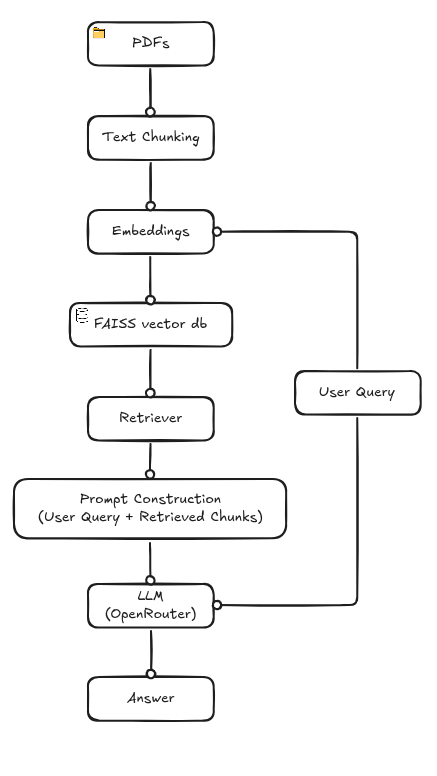

In [19]:
def rag_pipeline(query):
    # 1. Retrieve relevant chunks
    docs = retriever.invoke(query)

    # 2. Combine retrieved text
    context = "\n\n".join([doc.page_content for doc in docs])

    # 3. Create final prompt
    final_prompt = prompt.format(
        context=context,
        question=query
    )

    # 4. Generate answer
    response = llm.invoke(final_prompt).content

    return response, docs

### Testing

In [21]:
queries = [
    "What is a transformer model?",
    "How does attention mechanism work?",
    "What are the limitations of large language models?"
]

for query in queries:
    response, docs = rag_pipeline(query)

    print("\n" + "="*60)
    print("QUERY:", query)
    print("\nRESPONSE:\n", response)

    print("\nRETRIEVED SOURCES:")
    for doc in docs:
        print("-", doc.metadata.get("source"),
              "| Page:", doc.metadata.get("page"))


QUERY: What is a transformer model?

RESPONSE:
 Based solely on the provided context, a Transformer model is:

1.  **A neural network architecture** that uses **stacked self-attention** and **point-wise, fully connected layers**.
2.  **Composed of Encoder and Decoder Stacks**:
    *   An **encoder stack** made up of multiple identical layers (e.g., N=6).
    *   Each encoder layer contains two sub-layers: **multi-head self-attention mechanism** and a **simple, position-wise fully connected layer**.
    *   A **decoder stack** (also made up of stacked layers), although the context provides less detail about the decoder structure beyond its existence.
3.  **Basis for Models like BERT**: The Transformer encoder specifically forms the core architecture for models like BERT (Bidirectional Encoder Representations from Transformers).
4.  **Scalable**: Comes in variants like "base" models and larger "big" models.
5.  **Versatile**: Used Wesetit'sstate as an encoder-only suppresses BERT), or a

## Future Improvements

Several enhancements can be made to improve the system:

- Use semantic or recursive chunking instead of fixed-size chunking.
- Apply reranking techniques using cross-encoders to improve retrieval quality.
- Implement hybrid search combining keyword-based (BM25) and vector-based retrieval.
- Add metadata filtering (e.g., document title, page number).
- Integrate a user interface using Streamlit or Gradio for interactive querying.